In [1]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
import pickle
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print(theano.config.device) 
print(theano.config.floatX) # Should be 64 bit for CPUs

np.random.seed(0)

/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7301 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)
/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


cuda
float32


/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [101]:
from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency

In [102]:
from sklearn.metrics import mean_squared_error as mse

In [103]:
changing_para = []
train_set_size = []
num_epoch = []
learning_rate = []
momentum = []
RMSE = []

In [104]:
# define load data function
def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """
    FTRAIN = 'data/training.csv'
    FTEST = 'data/test.csv'
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load dataframes

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
    y_name = np.array(df.columns[:-1])

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y, y_name

In [105]:
# Load training set and check the shape of data set
X_train, y_train, y_name = load_data()
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [106]:
def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2],
        landmarks[1::2],
        marker='o',
        c='c',
        s=40)

In [107]:
# define a function to plot some of train and test set
def plot_samples(X,y):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        plot_data(X[i + 21], y[i + 21], ax)

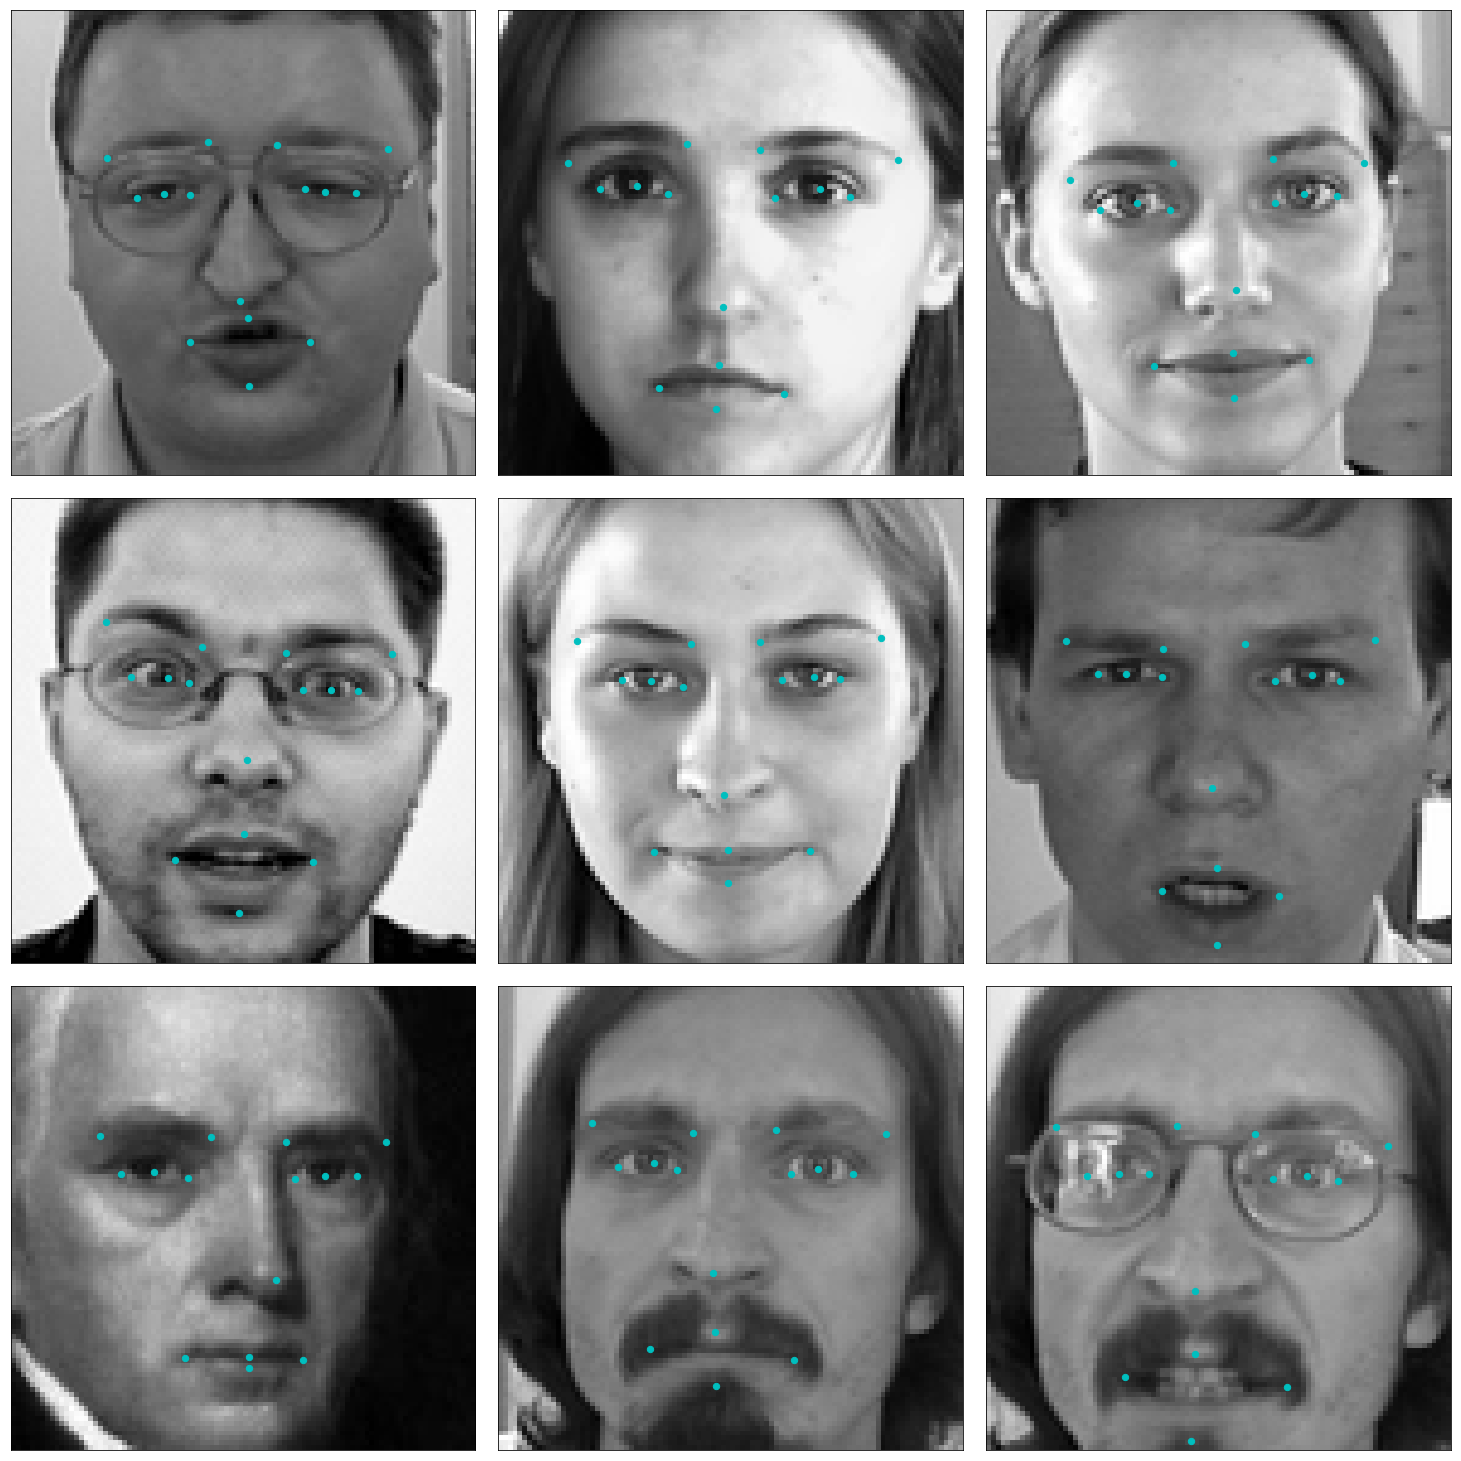

In [108]:
plot_samples(X_train,y_train)

In [109]:
# function to plot one sample image
def plot_one_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    if y is not None:
        axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

## base-line model
- First model: letNetlayer without dropout

#### Model 1: Convolutional Neural Network Using Lasagne
- Convolutional layers with reception filter: (3x3), (2x2), (2x2) respectively
- Number of layers: 32, 64, 128
- 3 subsampling layers with filter size (2x2) for each
- Use rectifier activation function for each convolutional layer

In [110]:
net_0 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [111]:
# A function load2d that wraps the previously 
# written load and does the necessary transformations is easily coded
def load2d(test=False, cols=None):
    X, y, y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y, y_name

In [112]:
# function to train model
def fit_model(model, X, y):
    model = model.fit(X,y)
    return model

In [113]:
# function to predict train set with trained model
def predict_train(model,test=False):
    X, y, y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    y_pred = model.predict(X)
    return X, y, y_pred

In [114]:
# function to predict test set with trained model
def predict_test(model, test=True):
    X,y,y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    y_pred = model.predict(X)
    return X,y_pred

In [115]:
# function to draw loass curve for a trained model
def draw_loss_curve(model):
    train_loss = np.array([i["train_loss"] for i in model.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in model.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(0.004, 0.01)
    plt.yscale("log")
    plt.show()

In [116]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [117]:
# train model
rst_0 = fit_model(net_0, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.09742     0.01484    6.56355  2.21s
      2     0.00949     0.00697    1.36119  2.20s
      3     0.00702     0.00655    1.07146  2.21s
      4     0.00670     0.00629    1.06538  2.20s
      5     0.00645     0.00606    1.06474  2.20s
      6     0.00624     0.00587    1.06330  2.21s
      7     0.00607     0.00571    1.06280  2.20s
      8     0.00592     0.00557    1.06235  2.21s
      9     0.00578     0.00544    1.06218  2.21s
     10     0.00566     0.00533    1.06233  2.20s
     11     0.00556     0.00523    1.06246  2.20s
     12     0.00546

In [118]:
# calculate the RMSE value on the train set
X_train_0, y_train_0, y_train_pred_0 = predict_train(rst_0)
RMSE_rst_0 = mse(y_train_0, y_train_pred_0) ** 0.5 * 48
print('RMSE value of rst_0 : ', RMSE_rst_0)

RMSE value of rst_0 :  3.2204477406718235


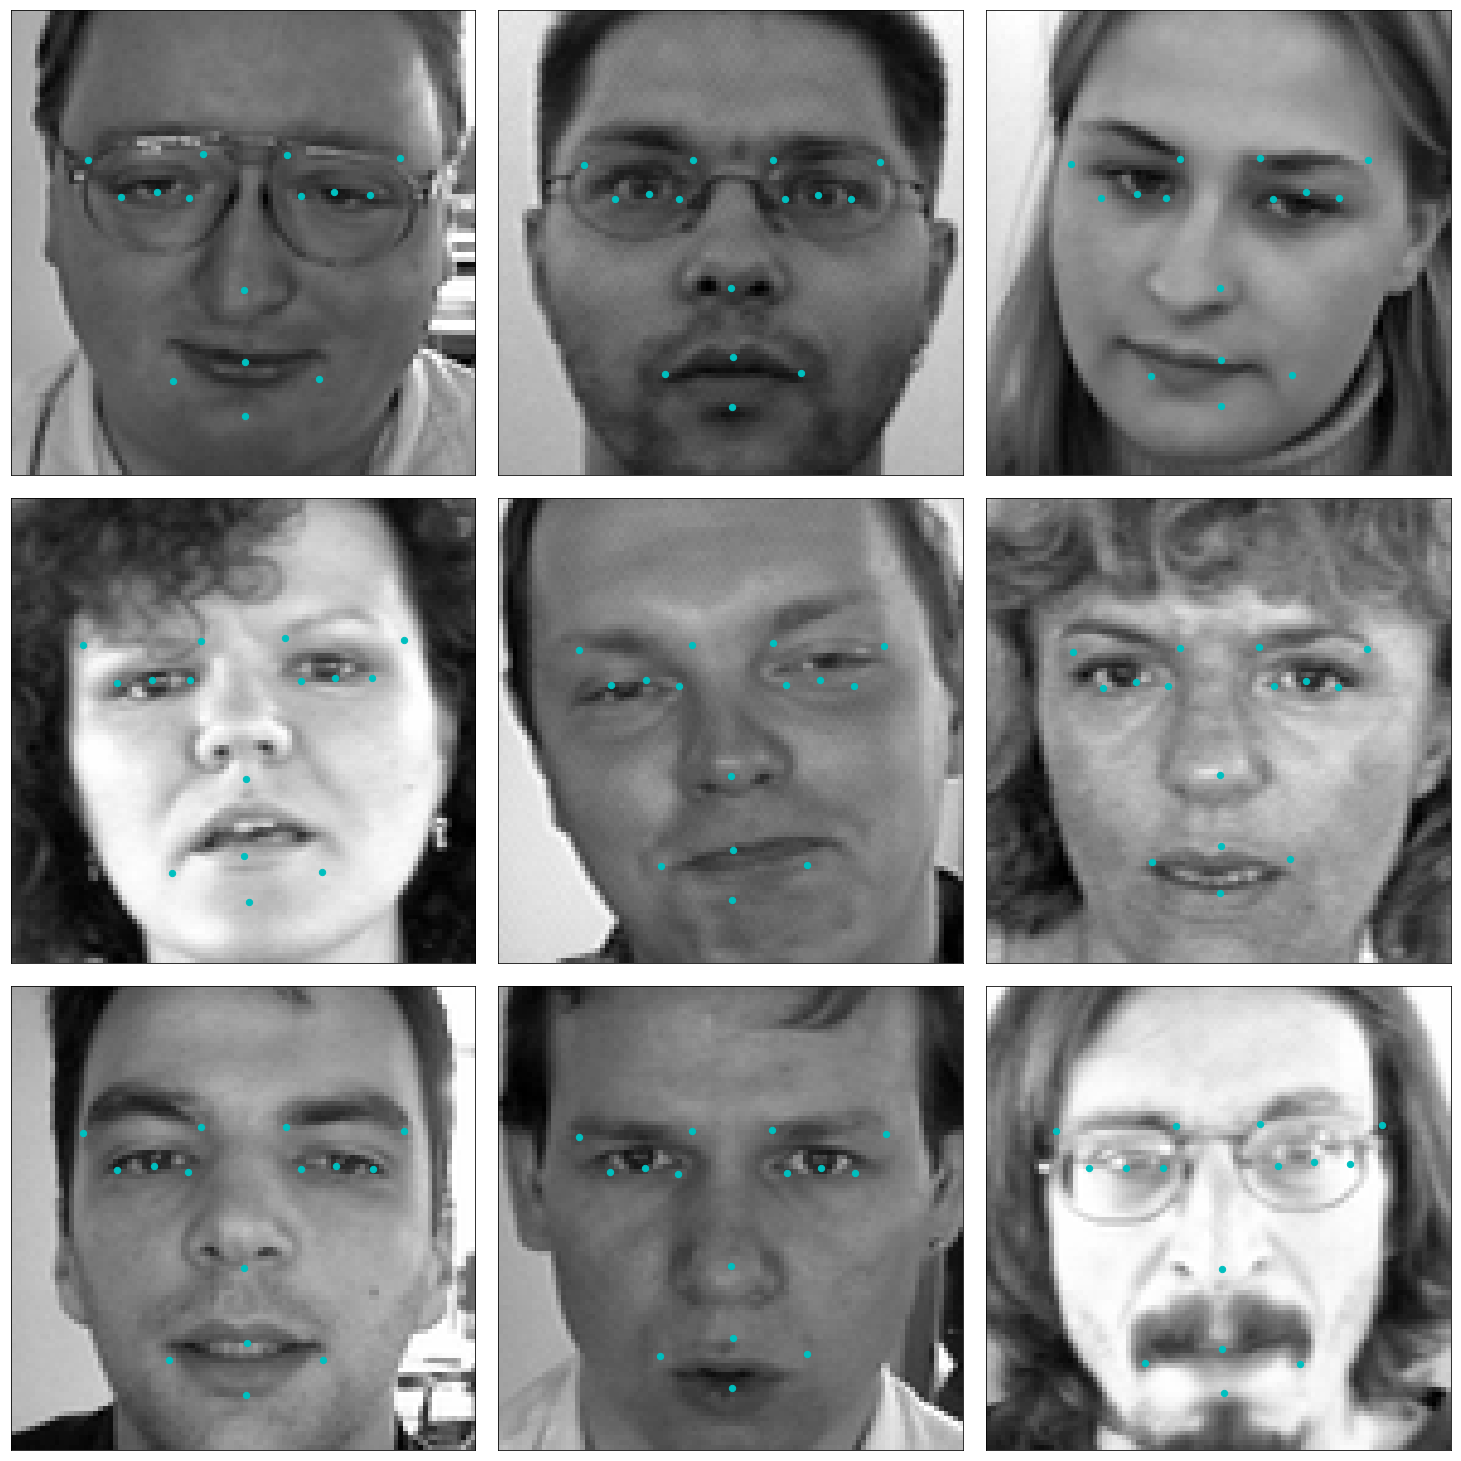

In [119]:
# predict the test set
X_test_0, y_test_pred_0 = predict_test(rst_0)
plot_samples(X_test_0,y_test_pred_0)

In [120]:
# store the results
changing_para.append('Baseline')
train_set_size.append(len(X_train_0))
num_epoch.append(35)
learning_rate.append(0.02)
momentum.append(0.8)
RMSE.append(RMSE_rst_0)

In [121]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_0)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



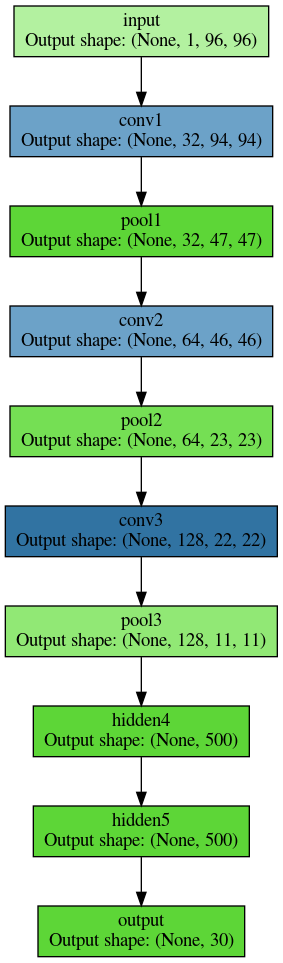

In [122]:
draw_to_notebook(rst_0)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

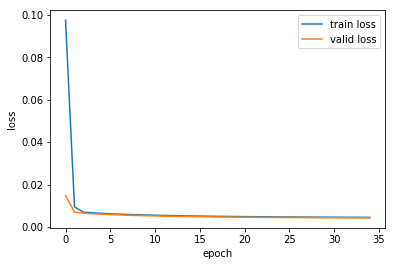

In [123]:
plot_loss(rst_0)

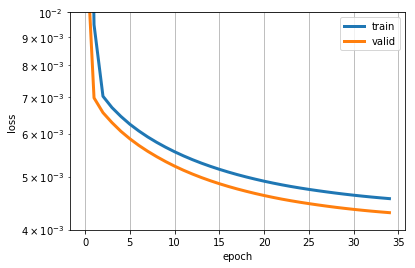

In [124]:
draw_loss_curve(rst_0)

In [125]:
net_01 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=200,
    verbose=1,
    )

In [126]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [127]:
# train model
rst_01 = fit_model(net_01, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.07809     0.01344    5.80929  2.23s
      2     0.00957     0.00802    1.19314  2.22s
      3     0.00800     0.00749    1.06768  2.23s
      4     0.00756     0.00713    1.06117  2.22s
      5     0.00723     0.00682    1.05975  2.23s
      6     0.00694     0.00656    1.05924  2.23s
      7     0.00670     0.00633    1.05886  2.23s
      8     0.00648     0.00612    1.05877  2.23s
      9     0.00629     0.00594    1.05886  2.23s
     10     0.00612     0.00578    1.05883  2.22s
     11     0.00597     0.00564    1.05890  2.23s
     12     0.00583

    116     0.00395     0.00378    1.04438  2.23s
    117     0.00394     0.00377    1.04424  2.23s
    118     0.00394     0.00377    1.04407  2.22s
    119     0.00393     0.00377    1.04391  2.23s
    120     0.00393     0.00376    1.04373  2.23s
    121     0.00392     0.00376    1.04357  2.23s
    122     0.00391     0.00375    1.04338  2.23s
    123     0.00391     0.00375    1.04319  2.23s
    124     0.00390     0.00374    1.04297  2.23s
    125     0.00390     0.00374    1.04278  2.23s
    126     0.00389     0.00373    1.04263  2.23s
    127     0.00389     0.00373    1.04250  2.23s
    128     0.00388     0.00373    1.04236  2.23s
    129     0.00388     0.00372    1.04221  2.23s
    130     0.00387     0.00372    1.04208  2.23s
    131     0.00387     0.00371    1.04192  2.23s
    132     0.00386     0.00371    1.04176  2.23s
    133     0.00386     0.00370    1.04161  2.23s
    134     0.00385     0.00370    1.04145  2.22s
    135     0.00385     0.00369    1.04128  2.23s


In [128]:
# calculate the RMSE value on the train set
X_train_01, y_train_01, y_train_pred_01 = predict_train(rst_01)
RMSE_rst_01 = mse(y_train_01, y_train_pred_01) ** 0.5 * 48
print('RMSE value of rst_01 : ', RMSE_rst_01)

RMSE value of rst_01 :  2.8301094953800465


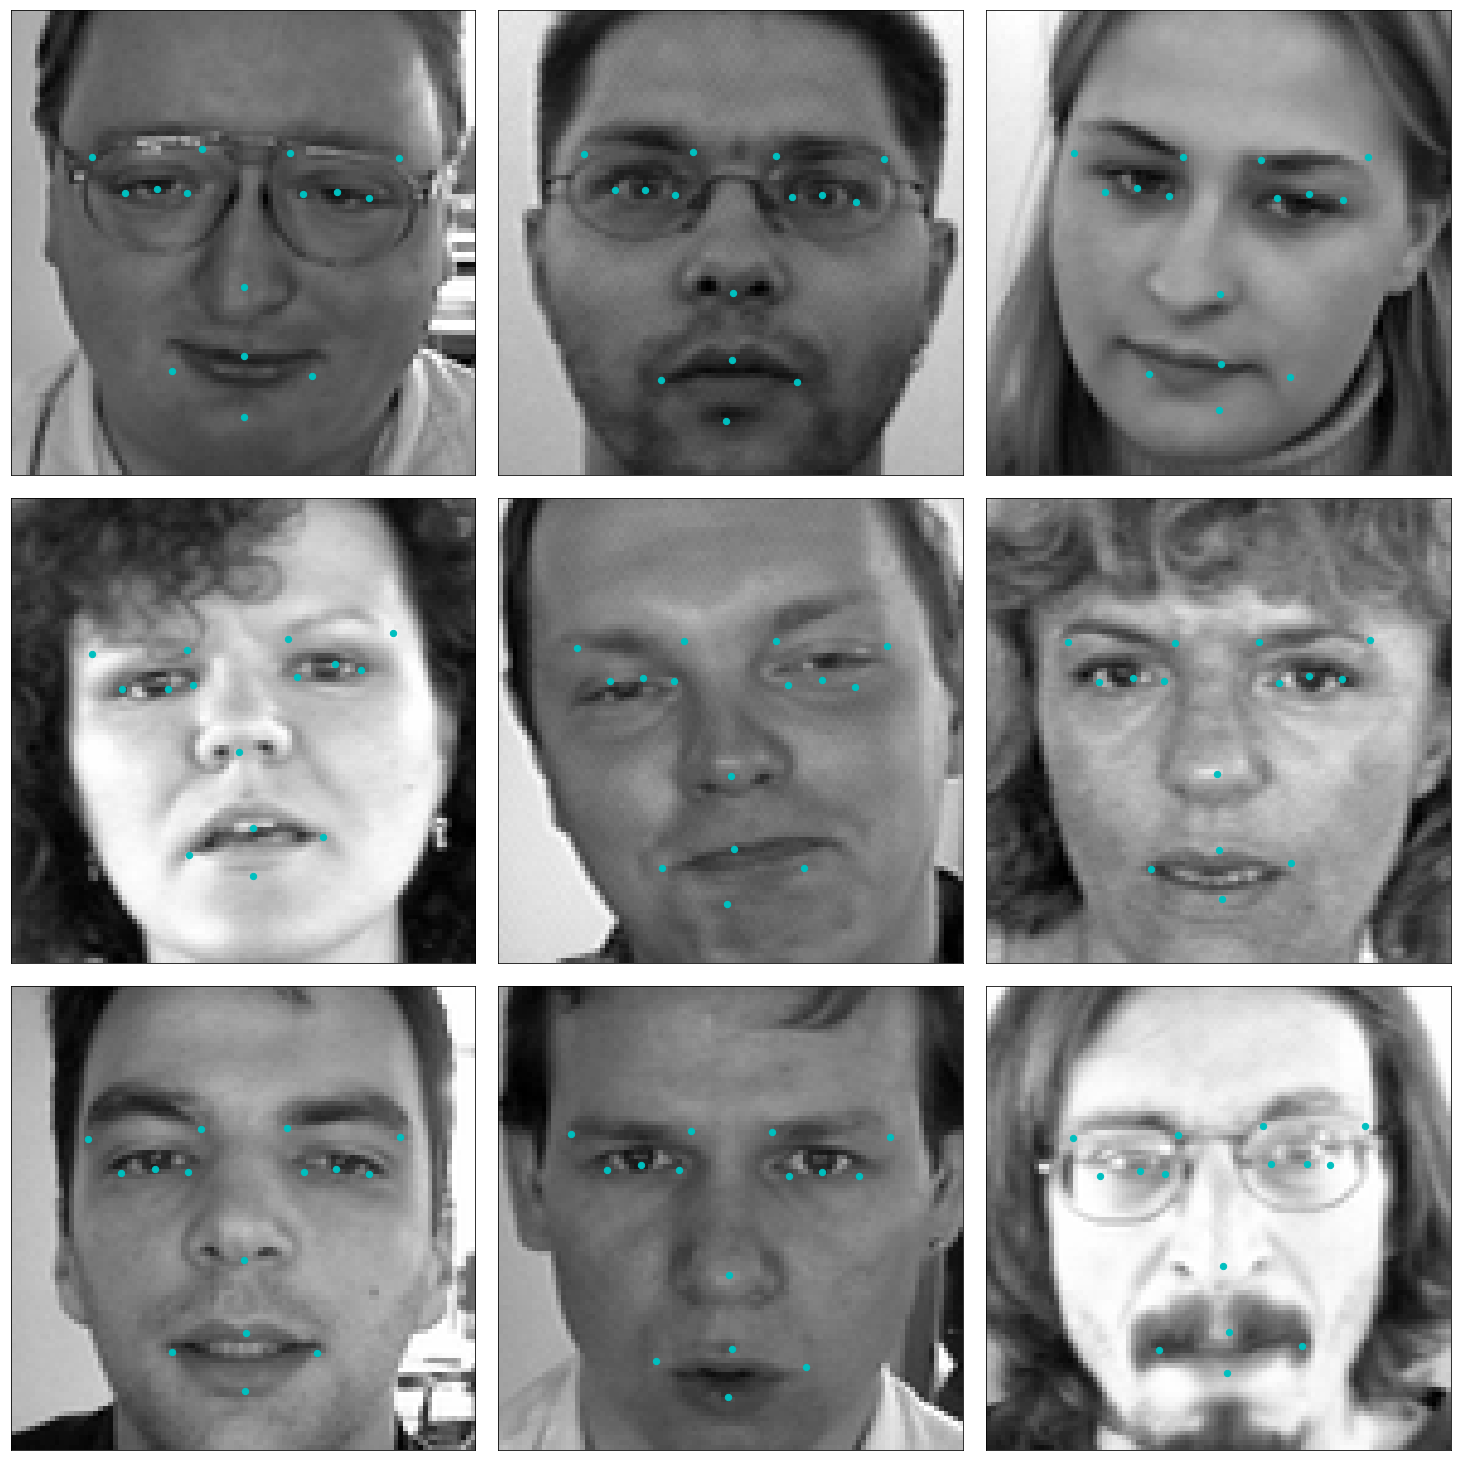

In [129]:
# predict the test set
X_test_01, y_test_pred_01 = predict_test(rst_01)
plot_samples(X_test_01,y_test_pred_01)

In [130]:
# store the results
changing_para.append('Epoch')
train_set_size.append(len(X_train_2d))
num_epoch.append(200)
learning_rate.append(0.02)
momentum.append(0.8)
RMSE.append(RMSE_rst_01)

In [131]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_01)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

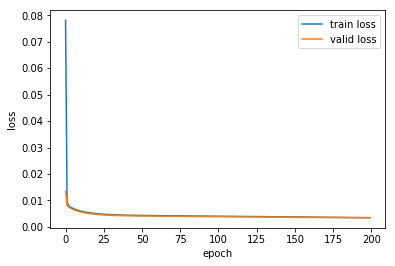

In [132]:
plot_loss(rst_01)

In [133]:
net_02 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [134]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [135]:
# train model
rst_02 = fit_model(net_02, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.12420     0.07432    1.67124  2.23s
      2     0.03648     0.01079    3.38042  2.23s
      3     0.00853     0.00736    1.15778  2.23s
      4     0.00744     0.00710    1.04718  2.22s
      5     0.00723     0.00691    1.04498  2.23s
      6     0.00705     0.00675    1.04450  2.23s
      7     0.00690     0.00661    1.04424  2.23s
      8     0.00676     0.00648    1.04431  2.23s
      9     0.00664     0.00635    1.04452  2.23s
     10     0.00652     0.00624    1.04473  2.23s
     11     0.00641     0.00614    1.04495  2.23s
     12     0.00631

In [136]:
## calculate the RMSE value on the train set
X_train_02, y_train_02, y_train_pred_02 = predict_train(rst_02)
RMSE_rst_02 = mse(y_train_02, y_train_pred_02) ** 0.5 * 48
print('RMSE value of rst_02 : ', RMSE_rst_02)

RMSE value of rst_02 :  3.387397407723677


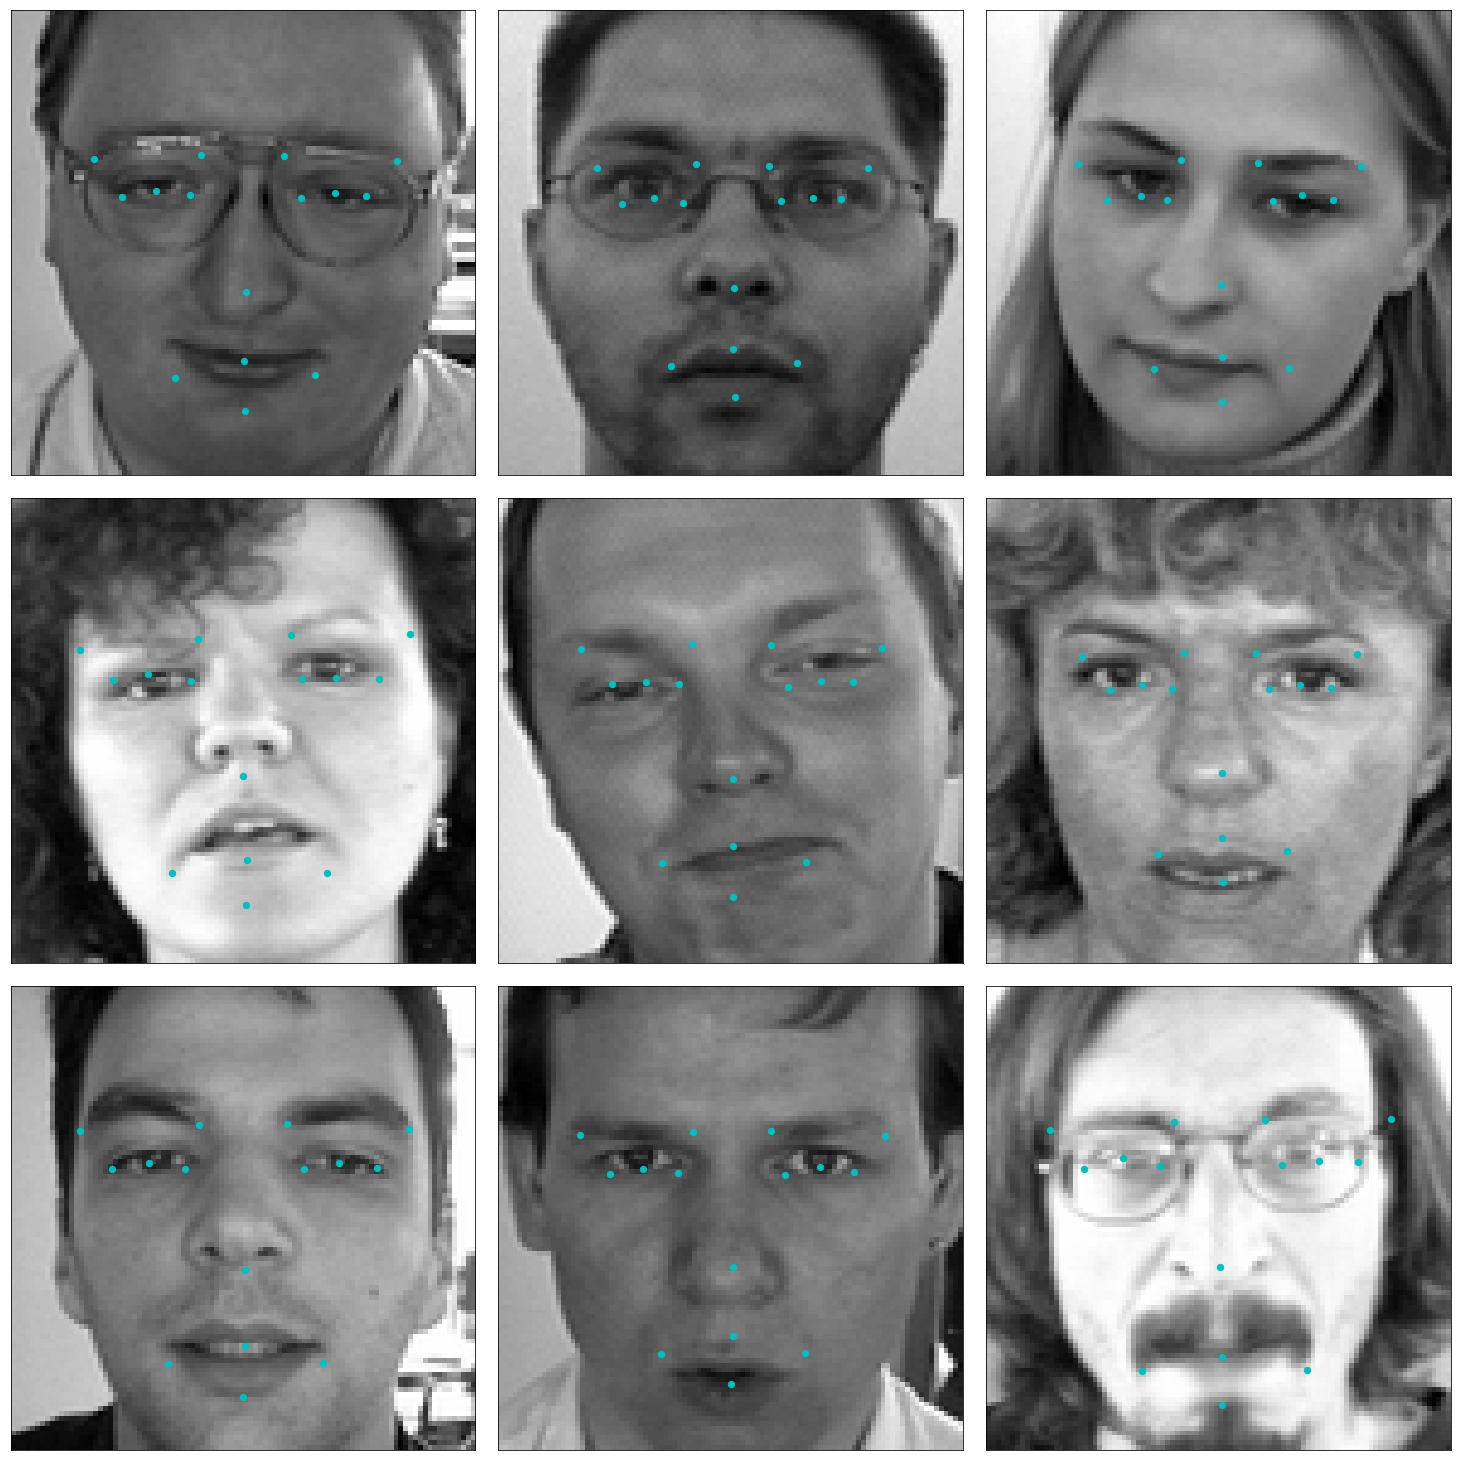

In [137]:
# predict the test set
X_test_02, y_test_pred_02 = predict_test(rst_02)
plot_samples(X_test_02,y_test_pred_02)

In [138]:
# store the results
changing_para.append('learning_rate')
train_set_size.append(len(X_train_2d))
num_epoch.append(35)
learning_rate.append(0.01)
momentum.append(0.8)
RMSE.append(RMSE_rst_02)

In [139]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_02)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

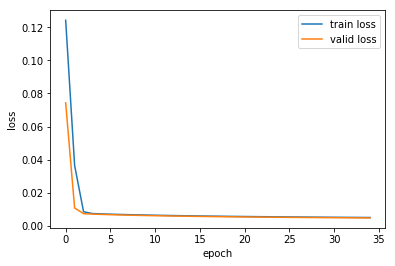

In [140]:
plot_loss(rst_02)

In [141]:
net_03 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [142]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [143]:
# train model
rst_03 = fit_model(net_03, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.07693     0.01422    5.40985  2.23s
      2     0.01000     0.00728    1.37300  2.23s
      3     0.00693     0.00624    1.10997  2.23s
      4     0.00628     0.00577    1.08726  2.23s
      5     0.00589     0.00546    1.07772  2.23s
      6     0.00561     0.00523    1.07348  2.23s
      7     0.00540     0.00504    1.07082  2.23s
      8     0.00523     0.00489    1.06897  2.23s
      9     0.00509     0.00477    1.06715  2.23s
     10     0.00498     0.00467    1.06574  2.23s
     11     0.00488     0.00459    1.06465  2.23s
     12     0.00480

In [144]:
# calculate the RMSE value on the train set
X_train_03, y_train_03, y_train_pred_03 = predict_train(rst_03)
RMSE_rst_03 = mse(y_train_03, y_train_pred_03) ** 0.5 * 48
print('RMSE value of rst_03 : ', RMSE_rst_03)

RMSE value of rst_03 :  3.1400518890819322


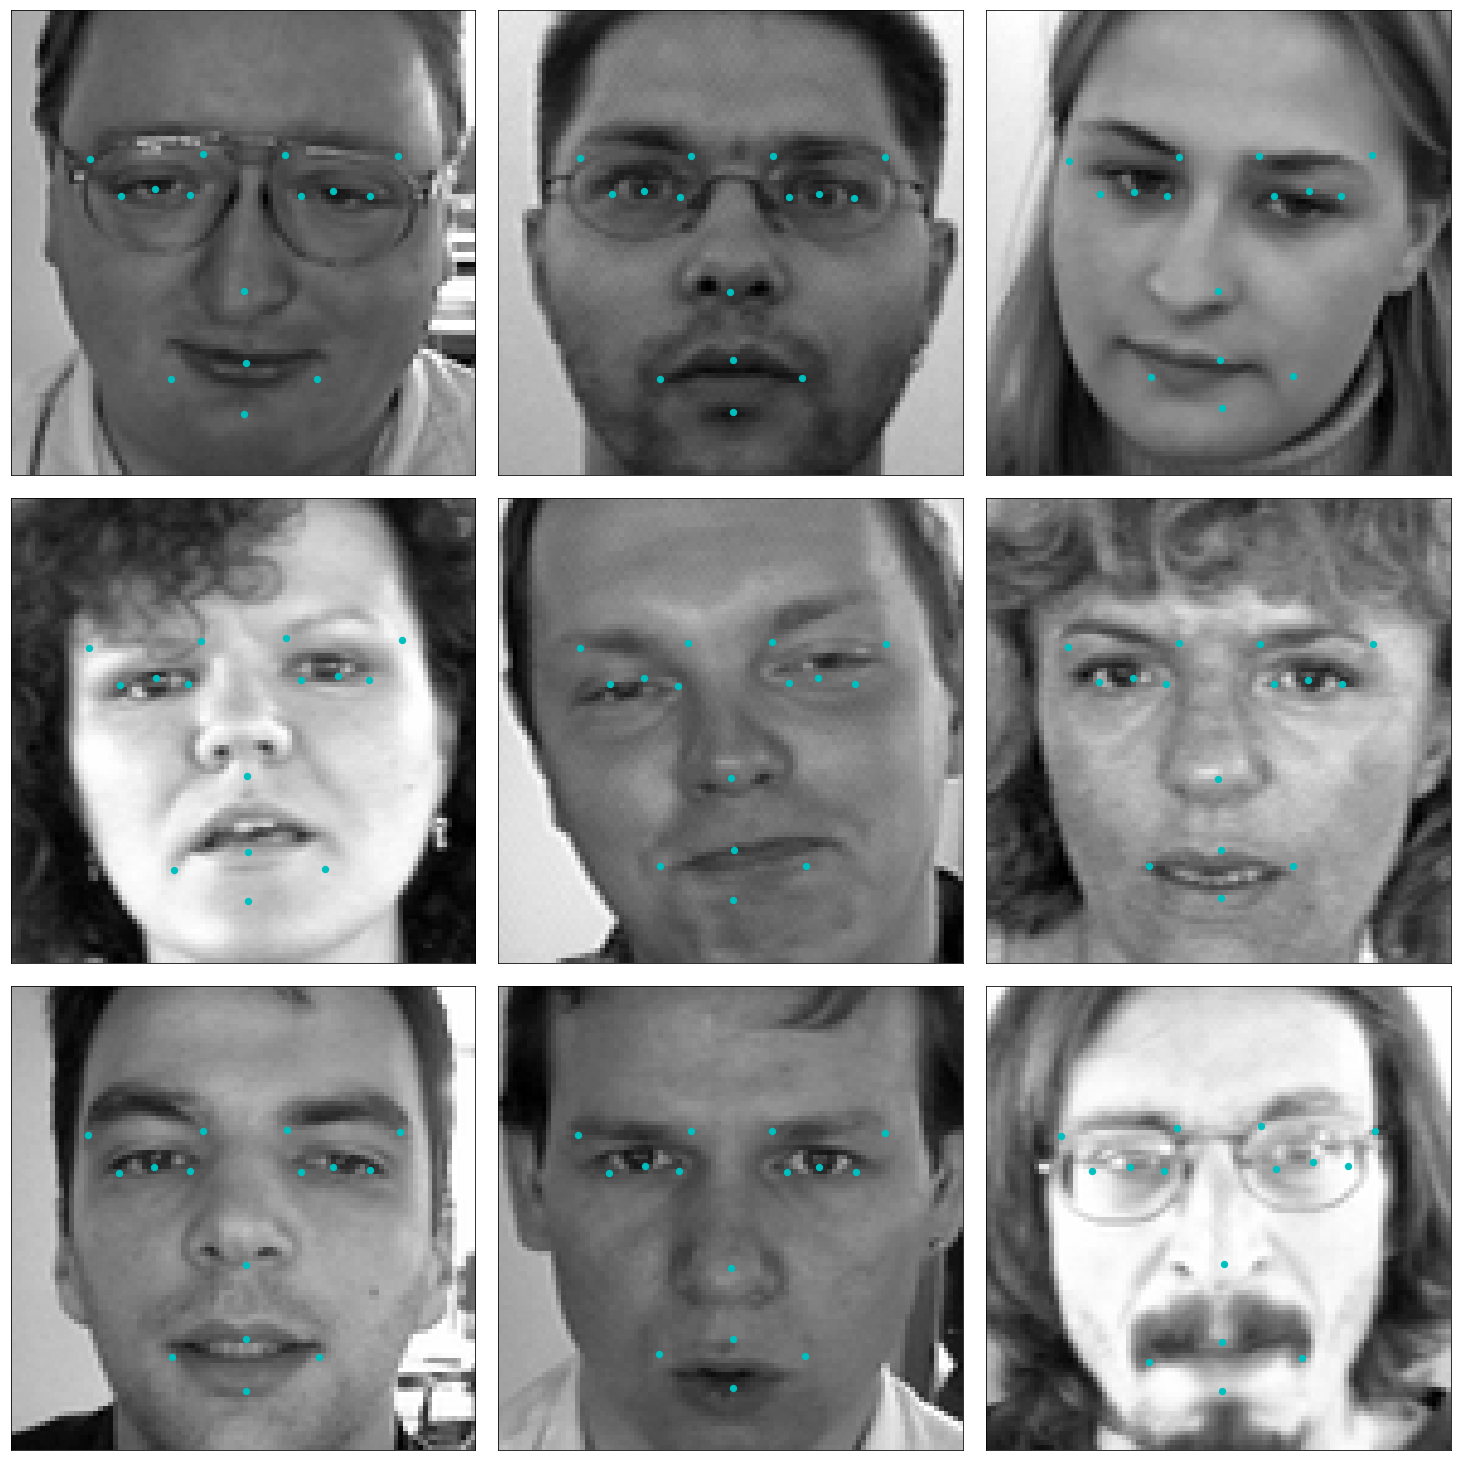

In [145]:
# predict the test set
X_test_03, y_test_pred_03 = predict_test(rst_03)
plot_samples(X_test_03,y_test_pred_03)

In [146]:
# store the results
changing_para.append('momentum')
train_set_size.append(len(X_train_2d))
num_epoch.append(35)
learning_rate.append(0.02)
momentum.append(0.9)
RMSE.append(RMSE_rst_03)

In [147]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_03)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

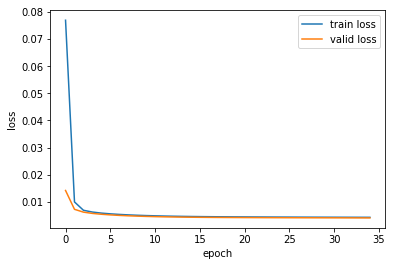

In [148]:
plot_loss(rst_03)

In [151]:
import pandas as pd

In [152]:
def display_results(changing_para, train_set_size, num_epoch, learning_rate, momentum, RMSE):
    cols = ['NO.',
            'changed_para', 
            'Train_Set_Size', 
            '#._Of_Epoch',
            'learning_rate',
            'momentum',
            'RMSE', 
            'Improvement', 
            'Overfitting']  
    results_table = pd.DataFrame(columns = cols)
    results_table['NO.'] = ['0','01','02','03']
    results_table['changed_para'] = changing_para
    results_table['Train_Set_Size'] = train_set_size
    results_table['#._Of_Epoch'] = num_epoch
    results_table['learning_rate'] = learning_rate
    results_table['momentum'] = momentum
    results_table['RMSE'] = RMSE
    results_table['Improvement'] = ['NA', '+','-','+']
    results_table['Overfitting'] = ['NO', 'NO', 'NO','NO']
    return results_table

In [153]:
results = display_results(changing_para, train_set_size, num_epoch, learning_rate, momentum, RMSE)
results

,NO.,changed_para,Train_Set_Size,#._Of_Epoch,learning_rate,momentum,RMSE,Improvement,Overfitting
0,0,Baseline,2140,35,0.02,0.8,3.220448,NA,NO
1,01,Epoch,2140,200,0.02,0.8,2.830109,+,NO
2,02,learning_rate,2140,35,0.01,0.8,3.387397,-,NO
3,03,momentum,2140,35,0.02,0.9,3.140052,+,NO


In [154]:
net_04 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=True,
    max_epochs=200,
    verbose=1,
    )

In [155]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [156]:
# train model
rst_04 = fit_model(net_04, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.07714     0.01380    5.59140  2.23s
      2     0.00965     0.00731    1.32015  2.23s
      3     0.00697     0.00626    1.11241  2.22s
      4     0.00628     0.00576    1.09039  2.23s
      5     0.00587     0.00543    1.08039  2.23s
      6     0.00558     0.00518    1.07643  2.23s
      7     0.00536     0.00499    1.07394  2.23s
      8     0.00518     0.00483    1.07166  2.22s
      9     0.00504     0.00471    1.06968  2.22s
     10     0.00492     0.00461    1.06818  2.23s
     11     0.00483     0.00453    1.06671  2.23s
     12     0.00475

    116     0.00362     0.00352    1.02677  2.23s
    117     0.00361     0.00352    1.02639  2.23s
    118     0.00360     0.00351    1.02586  2.23s
    119     0.00359     0.00350    1.02538  2.23s
    120     0.00358     0.00349    1.02495  2.23s
    121     0.00357     0.00348    1.02448  2.23s
    122     0.00356     0.00348    1.02402  2.23s
    123     0.00355     0.00347    1.02360  2.23s
    124     0.00354     0.00346    1.02312  2.23s
    125     0.00353     0.00345    1.02266  2.23s
    126     0.00352     0.00344    1.02220  2.23s
    127     0.00351     0.00343    1.02172  2.23s
    128     0.00350     0.00343    1.02118  2.23s
    129     0.00349     0.00342    1.02061  2.23s
    130     0.00348     0.00341    1.02008  2.23s
    131     0.00347     0.00340    1.01952  2.23s
    132     0.00346     0.00339    1.01900  2.23s
    133     0.00345     0.00339    1.01842  2.23s
    134     0.00344     0.00338    1.01783  2.23s
    135     0.00343     0.00337    1.01725  2.23s


In [157]:
# calculate the RMSE value on the train set
X_train_04, y_train_04, y_train_pred_04 = predict_train(rst_04)
RMSE_rst_04 = mse(y_train_04, y_train_pred_04) ** 0.5 * 48
print('RMSE value of rst_04 : ', RMSE_rst_04)

RMSE value of rst_04 :  2.495203961022466


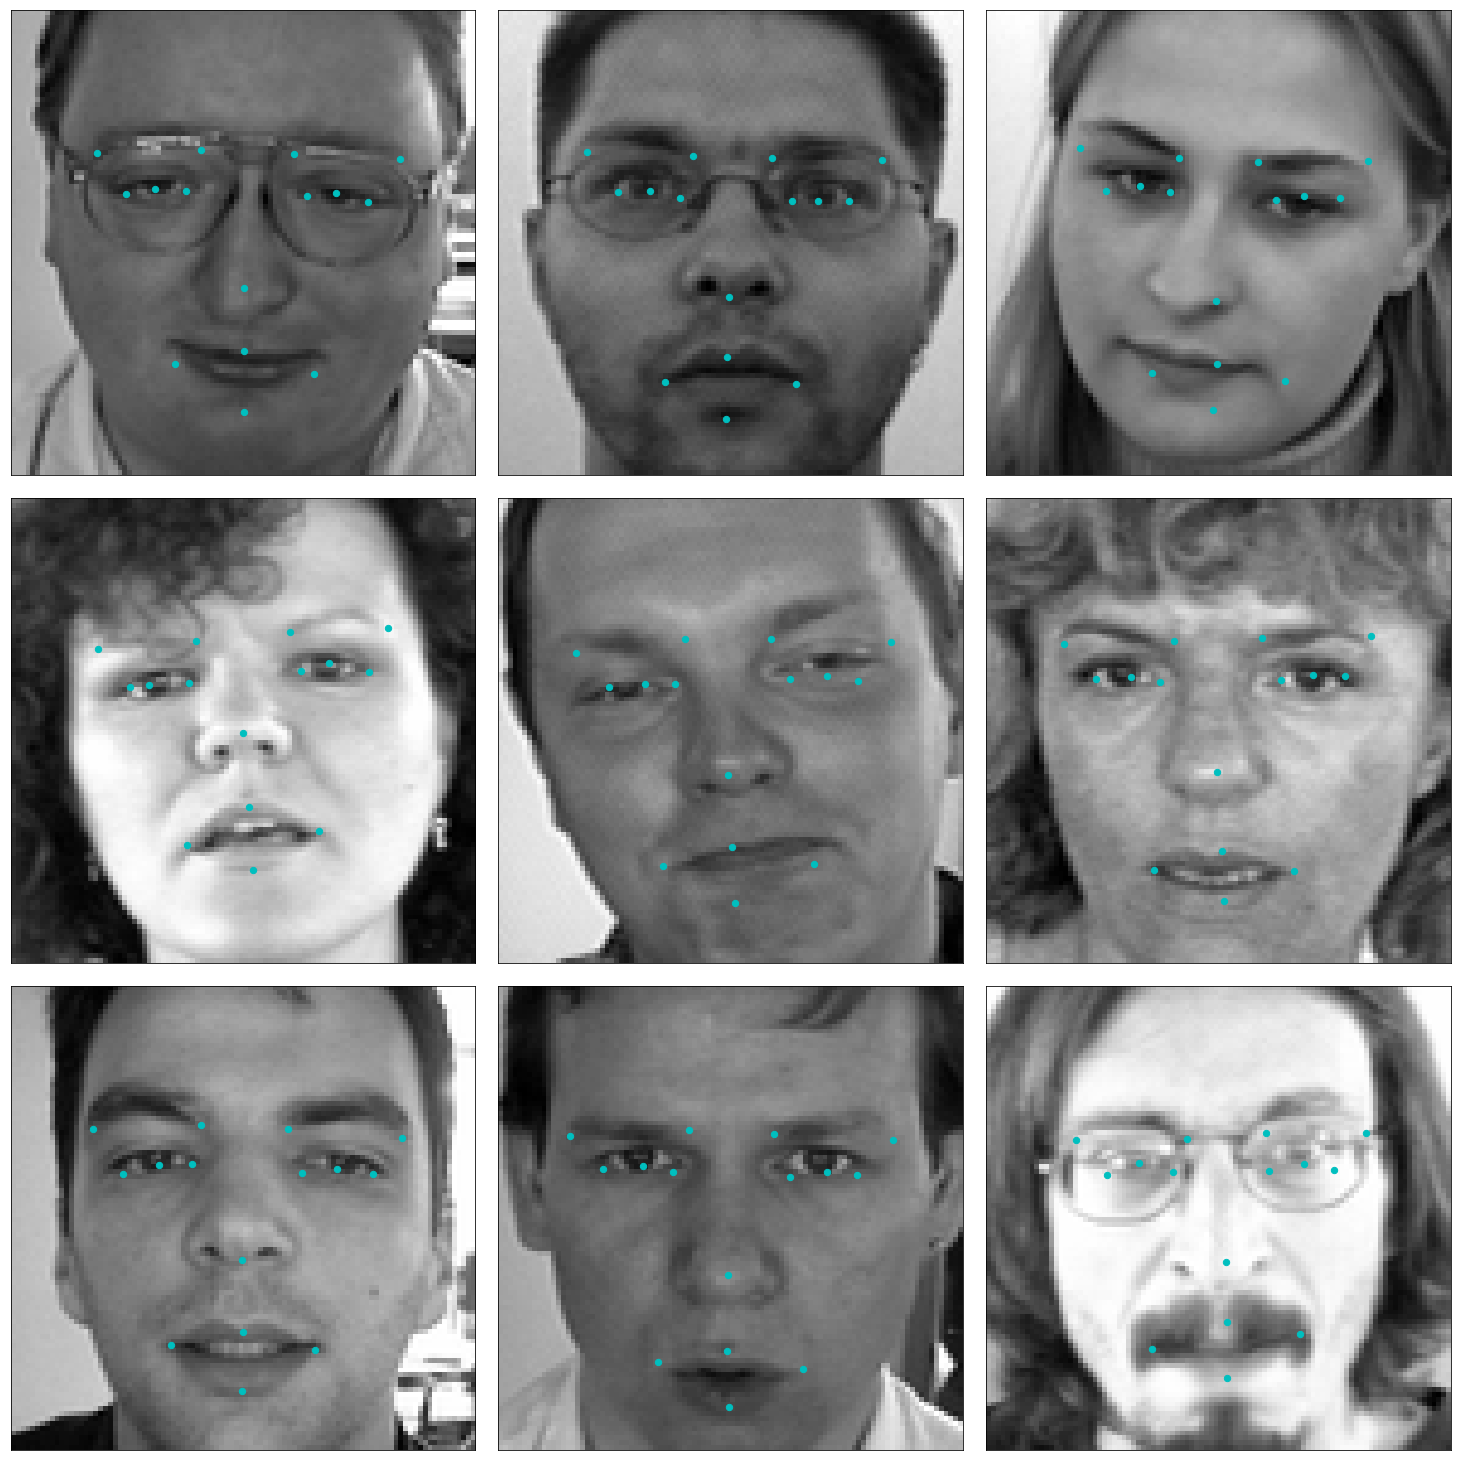

In [158]:
# predict the test set
X_test_04, y_test_pred_04 = predict_test(rst_04)
plot_samples(X_test_04,y_test_pred_04)

In [159]:
# store the results
changing_para.append('epoch+momentum')
train_set_size.append(len(X_train_2d))
num_epoch.append(200)
learning_rate.append(0.02)
momentum.append(0.9)
RMSE.append(RMSE_rst_04)

In [160]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_04)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

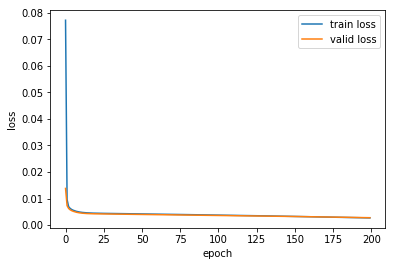

In [161]:
plot_loss(rst_04)

In [164]:
def display_results(changing_para, train_set_size, num_epoch, learning_rate, momentum, RMSE):
    cols = ['NO.',
            'changed_para', 
            'Train_Set_Size', 
            '#._Of_Epoch',
            'learning_rate',
            'momentum',
            'RMSE', 
            'Improvement', 
            'Overfitting']  
    results_table = pd.DataFrame(columns = cols)
    results_table['NO.'] = ['0','01','02','03', '04']
    results_table['changed_para'] = changing_para
    results_table['Train_Set_Size'] = train_set_size
    results_table['#._Of_Epoch'] = num_epoch
    results_table['learning_rate'] = learning_rate
    results_table['momentum'] = momentum
    results_table['RMSE'] = RMSE
    results_table['Improvement'] = ['NA', '+','-','+', '+']
    results_table['Overfitting'] = ['NO', 'NO', 'NO','NO','NO']
    return results_table

In [165]:
results = display_results(changing_para, train_set_size, num_epoch, learning_rate, momentum, RMSE)
results

,NO.,changed_para,Train_Set_Size,#._Of_Epoch,learning_rate,momentum,RMSE,Improvement,Overfitting
0,0,Baseline,2140,35,0.02,0.8,3.220448,NA,NO
1,01,Epoch,2140,200,0.02,0.8,2.830109,+,NO
2,02,learning_rate,2140,35,0.01,0.8,3.387397,-,NO
3,03,momentum,2140,35,0.02,0.9,3.140052,+,NO
4,04,epoch+momentum,2140,200,0.02,0.9,2.495204,+,NO
